# **ETL** y **EDA** de los archivos de **YELP**

### Importar las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from textblob import TextBlob

In [2]:
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="darkgrid")

## **_`REVIEW`_**

Primero se va extraer review que está en formato .json y luego se va transformar a formato .parquet con la finalidad de ahorrar memoria y trabajar solo con el archivo en formato parquet.

In [ ]:
data = []
with open('Yelp/review-001.json', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))
df_review = pd.DataFrame(data)

Se visualiza las primera 3 filas para saber lo que contiene el dataframe

In [ ]:
df_review.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


Ahora se va convertir el archivo a formato .parquet con la finalidad de ahorrar espacio

In [ ]:
df_review.to_parquet('Yelp/review.parquet', index=False)

Ahora se va a eliminar"df_review"

In [ ]:
del df_review

Apartir de aquí se trabajará con el archivo review.parquet

In [3]:
df_review = pd.read_parquet('Yelp/review.parquet')
df_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.00,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.00,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [ ]:
df_review.shape

(6990280, 9)

Verificar el periodo de los datos

In [5]:
df_review['date'] = pd.to_datetime(df_review['date'])

fecha_maxima = df_review['date'].max()
fecha_minima = df_review['date'].min()

In [ ]:
print(f"El periodo es desde {fecha_maxima}")
print(f'hasta {fecha_minima}')

El periodo es desde 2022-01-19 19:48:45
hasta 2005-02-16 03:23:22


Se filtran los datos a partir del 2015, porque reseñas más antiguas no van a ser adecuadas para el estudio

In [6]:
df_review_desde_2015 = df_review[df_review['date'].dt.year >= 2015]

In [ ]:
df_review_desde_2015.shape

(5285402, 9)

Ahora se verifica la existencia de valores nulos

In [7]:
df_review_desde_2015.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

No existen valores nulos

### Verificar la existencia de valores duplicados

Se verificará la existencia de valores duplicados por _`review_id`_, porque debe haber solo un ID por review

In [8]:
df_review_desde_2015['review_id'].duplicated().any()

False

No existen valores duplicados por _`review_id`_

Ahora verifiquemos si existen valores duplicados por _`business_id`_

In [9]:
df_review_desde_2015['business_id'].duplicated().any()

True

In [ ]:
df_review_desde_2015['business_id'].value_counts()

business_id
ac1AeYqs8Z4_e2X5M3if2A    6598
GXFMD0Z4jEVZBCsbPf4CTQ    5529
_ab50qdWOk0DdB6XOrBitw    5297
oBNrLz4EDhiscSlbOl8uAw    4540
1b5mnK8bMnnju_cvU65GqQ    4219
                          ... 
hgbgnJliD3XlbOaTQ1gLDg       1
fAvMcLEBVllP7HEbO2IjDQ       1
eFhwjZ8f_55bdeV5PUy2bg       1
4jenHtiK6VGpe_VRG31j6w       1
HaSEQCVzuVuMtJD_vVlfVg       1
Name: count, Length: 143028, dtype: int64

Existen muchas columnas duplicadas por _`business_id`_, lo cual es normal, porque para un negocio pueden haber muchas reseñas

En el EDA, es esencial entender la composición y las características de los datos que estamos utilizando. Las funciones: **df.info(), df.describe()** son herramientas valiosas para obtener información clave sobre un DataFrame.

In [10]:
df_review_desde_2015.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5285402 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        float64       
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 403.2+ MB


In [ ]:
df_review_desde_2015.describe()

,stars,useful,funny,cool,date
count,5285402.00,5285402.00,5285402.00,5285402.00,5285402
mean,3.76,1.04,0.26,0.47,2018-05-31 02:41:25.534669568
min,1.00,-1.00,-1.00,-1.00,2015-01-01 00:00:05
25%,3.00,0.00,0.00,0.00,2016-10-22 23:49:14
50%,4.00,0.00,0.00,0.00,2018-05-31 14:20:54.500000
75%,5.00,1.00,0.00,0.00,2019-11-05 22:09:10
max,5.00,1182.00,792.00,304.00,2022-01-19 19:48:45
std,1.52,3.12,1.40,2.14,NaN


### Visualizar el número de reseñas por año

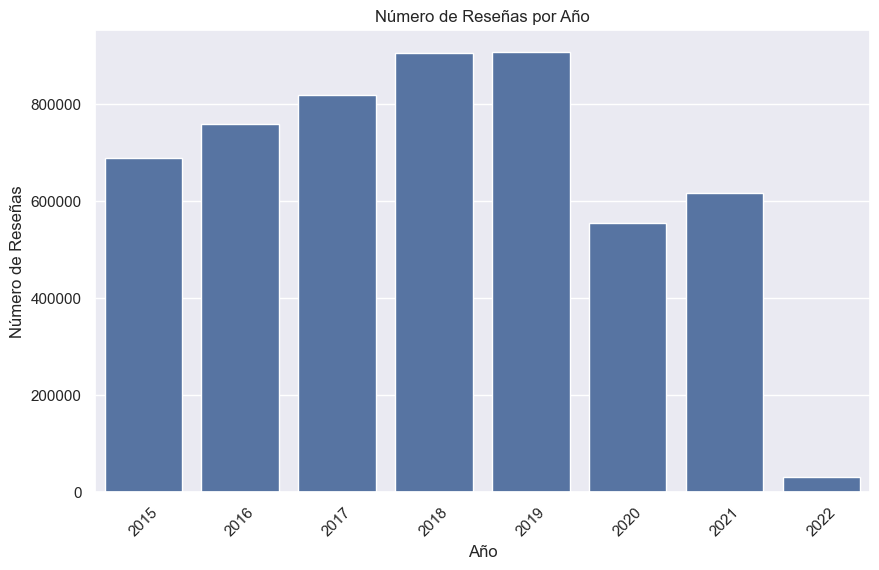

In [12]:
reviews_por_año = df_review_desde_2015.groupby(df_review_desde_2015['date'].dt.year)['review_id'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=reviews_por_año, x='date', y='review_id', color='#4A71AF')
plt.xlabel('Año')
plt.ylabel('Número de Reseñas')
plt.title('Número de Reseñas por Año')
plt.xticks(rotation=45)
plt.show()

In [ ]:
reviews_por_año

,date,review_id
0,2015,688415
1,2016,758882
2,2017,820048
3,2018,906362
4,2019,907284
5,2020,554557
6,2021,618189
7,2022,31665


### Distribución de calificaciones

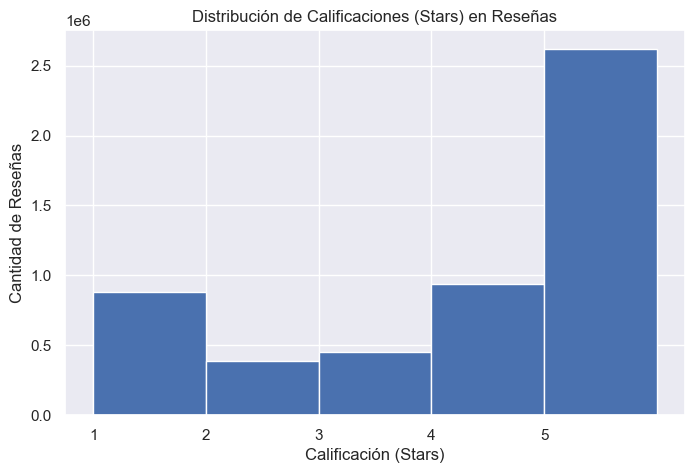

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(df_review_desde_2015['stars'], bins=[1, 2, 3, 4, 5, 6], color='#4A71AF')

plt.title('Distribución de Calificaciones (Stars) en Reseñas')
plt.xlabel('Calificación (Stars)')
plt.ylabel('Cantidad de Reseñas')

plt.xticks([1, 2, 3, 4, 5])

plt.show()

Se observa que la barra correspondiente a la calificación 5 es la más alta, lo que significa que la mayoría de las reseñas han recibido una calificación de 5 estrellas. Esto podría indicar que muchas reseñas son positivas. Las barras para las calificaciones más bajas (1, 2, 3) son muy pocas, entonces hay menos reseñas con calificaciones más bajas.

## **_`USER`_**

El archivo user está en formato parquet, entonces lo abriremos como dataframe

In [ ]:
df_user = pd.read_parquet('Yelp/user-002.parquet')
df_user.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946


También se verifica el tamaño y la existencia de valores nulos

In [ ]:
df_user.shape

(2105597, 22)

In [ ]:
df_user.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

No existen valores nulos

Las columnas _`elite`_, _`friends`_, _`fans`_, _`compliment_hot`_, _`compliment_more`_, _`compliment_profile`_, _`compliment_cute`_, _`compliment_list`_, _`compliment_note`_, _`compliment_plain`_, _`compliment_cool`_, _`compliment_funny`_, _`compliment_writer`_ y _`compliment_photos`_ están más relacionadas con el usuario que con las reseñas. No se trabajaran con estas variables porque no van a aportar mucho al análisis.

El **nuevo dataframe filtrado** es el siguiente:

In [ ]:
user_filtrado = df_user[['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'average_stars']]

In [ ]:
user_filtrado.shape

(2105597, 8)

In [ ]:
user_filtrado.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,average_stars
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,3.91
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,3.74


### Verificar la existencia de valores duplicados

Se verificará la existencia de valores duplicados por _`user_id`_ y _`name`_, porque debe haber solo un ID por usuario

**_`user_id`_**

In [ ]:
user_filtrado['user_id'].duplicated().any()

True

In [ ]:
user_filtrado['user_id'].value_counts()

user_id
T5gvmAML_EAA9invlLymJg    5
-J_wra_v8PaPfy2r4_LHiw    5
a25SLDRY8NLhISUucSBZJg    5
zWeCH5pffPS1adw57xzaWA    5
vRYjn0Ip0Zu7SnJYQp9P3Q    5
                         ..
0SGduwsWeTWeL9Sj6pGfyw    1
ManF7sVLflO-i9qWh-oD5g    1
8WCxUvUu8ECp4779Sj5AkA    1
wmSh-O8JDehKBc4QsVUFuw    1
wL5jPrLRVCK_Pmo4lM1zpA    1
Name: count, Length: 1987897, dtype: int64

In [ ]:
user_filtrado[user_filtrado['user_id'] == 'T5gvmAML_EAA9invlLymJg']

,user_id,name,review_count,yelping_since,useful,funny,cool,average_stars
21649,T5gvmAML_EAA9invlLymJg,Jason,9,2012-10-08 00:45:33,6,0,3,4.64
2011746,T5gvmAML_EAA9invlLymJg,Jason,9,2012-10-08 00:45:33,6,0,3,4.64
2032846,T5gvmAML_EAA9invlLymJg,Jason,9,2012-10-08 00:45:33,6,0,3,4.64
2053946,T5gvmAML_EAA9invlLymJg,Jason,9,2012-10-08 00:45:33,6,0,3,4.64
2075046,T5gvmAML_EAA9invlLymJg,Jason,9,2012-10-08 00:45:33,6,0,3,4.64


Se eliminarán los registros repetidos por _`user_id`_

In [ ]:
user_filtrado = user_filtrado.drop_duplicates(subset='user_id').copy()

In [ ]:
user_filtrado.shape

(1987897, 8)

**_`name`_**

In [ ]:
user_filtrado['name'].duplicated().any()

True

In [ ]:
user_filtrado['name'].value_counts()

name
John         18719
Michael      16645
David        15967
Chris        14591
Mike         13390
             ...  
Udochukwu        1
Trak             1
Rhaya            1
Mikiya           1
Gwendy           1
Name: count, Length: 132361, dtype: int64

Efectivamente, hay muchos nombres duplicados, pero no se eliminaran registros duplicados por nombre, porque varias personas pueden tener el mismo nombre, es solo coincidencia.

En el EDA, es esencial entender la composición y las características de los datos que estamos utilizando. Las funciones: **df.info(), df.describe()** son herramientas valiosas para obtener información clave sobre un DataFrame.

In [ ]:
user_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987897 entries, 0 to 1987896
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   review_count   int64  
 3   yelping_since  object 
 4   useful         int64  
 5   funny          int64  
 6   cool           int64  
 7   average_stars  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 136.5+ MB


In [ ]:
user_filtrado.describe()

,review_count,useful,funny,cool,average_stars
count,1987897.00,1987897.00,1987897.00,1987897.00,1987897.00
mean,23.39,42.30,16.97,23.79,3.63
std,82.57,641.48,407.80,565.35,1.18
min,0.00,0.00,0.00,0.00,1.00
25%,2.00,0.00,0.00,0.00,3.00
50%,5.00,3.00,0.00,0.00,3.88
75%,17.00,13.00,2.00,3.00,4.56
max,17473.00,206296.00,185823.00,199878.00,5.00


## **_`BUSINESS`_**

Se comienza importando el archivo "business" de la base de datos de yelp

In [3]:
with open('Yelp/business.pkl', 'rb') as file:
    business = pd.read_pickle(file)

In [4]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.43,-119.71,5.00,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.55,-90.34,3.00,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


se corrobora las dimensiones del dataset

In [ ]:
business.shape

(150346, 28)

Se corrobora cantidad de valores nulos por columna, y nombres de columnas

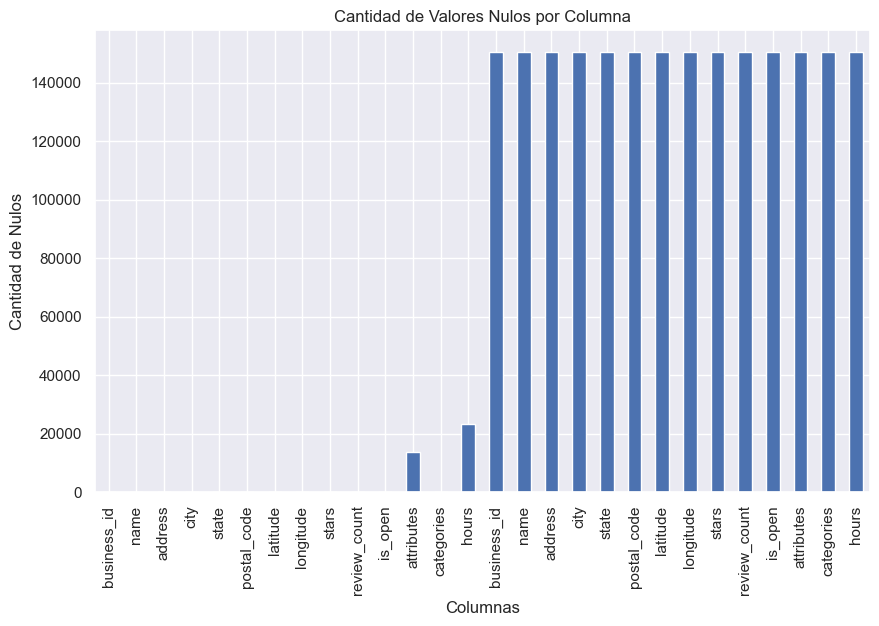

In [5]:
# Se cuentan los valores nulos por columna
null_counts = business.isnull().sum()

# Se crea el gráfico
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Nulos')
plt.show()

Se observa que existen columnas duplicadas, entonces se van a eliminar

In [6]:
business = business.loc[:, ~business.columns.duplicated()]

visualizamos con esta reducción de datos una vez más los nulos

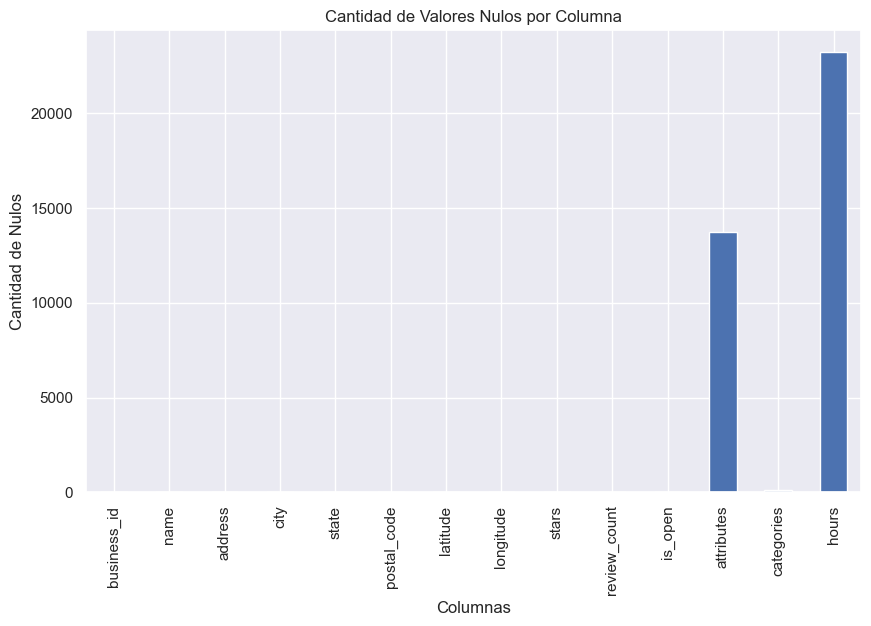

In [7]:
# Se cuentan los valores nulos por columna
null_counts = business.isnull().sum()

# Se crea el gráfico
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Nulos')
plt.show()

se observa que las columnas _`attributes`_ y _`hours`_ presentan una cantidad significativa de nulos, para ahondar un poco más esta cuestión se corrobora esta información en términos de porcentajes

##### Porcentajes de nulos para las columnas "attributes" y "hours"

In [8]:
# Se calcula el porcentaje de nulos en las columnas 'attributes' y 'hours'
attributes_null_percentage = (business["attributes"].isnull().sum() / len(business)) * 100
hours_null_percentage = (business["hours"].isnull().sum() / len(business)) * 100

# Se imprime los porcentajes de nulos con formato
print("Porcentaje de nulos en la columna 'attributes': {:.2f}%".format(attributes_null_percentage))
print("Porcentaje de nulos en la columna 'hours': {:.2f}%".format(hours_null_percentage))

Porcentaje de nulos en la columna 'attributes': 9.14%
Porcentaje de nulos en la columna 'hours': 15.45%


In [ ]:
business.dtypes

business_id     object
name            object
address         object
city            object
state           object
postal_code     object
latitude        object
longitude       object
stars           object
review_count    object
is_open         object
attributes      object
categories      object
hours           object
dtype: object

##### Columnas hours contiene datos anidados

In [9]:
business["hours"].head(10)

0                                                 None
1    {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...
2    {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...
3    {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...
4    {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...
5    {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...
6    {'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ...
7    {'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ...
8                                                 None
9    {'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...
Name: hours, dtype: object

##### Se elimina hours

In [9]:
business.drop(columns=['hours'], inplace=True)

### Columna Atributes

por lo anterior, si se elimina _`Atributes`_ se está sacano el 9% de los datos aprox

In [10]:
business.drop(columns=['attributes'], inplace=True)

se corrobora cuántos nulos quedan

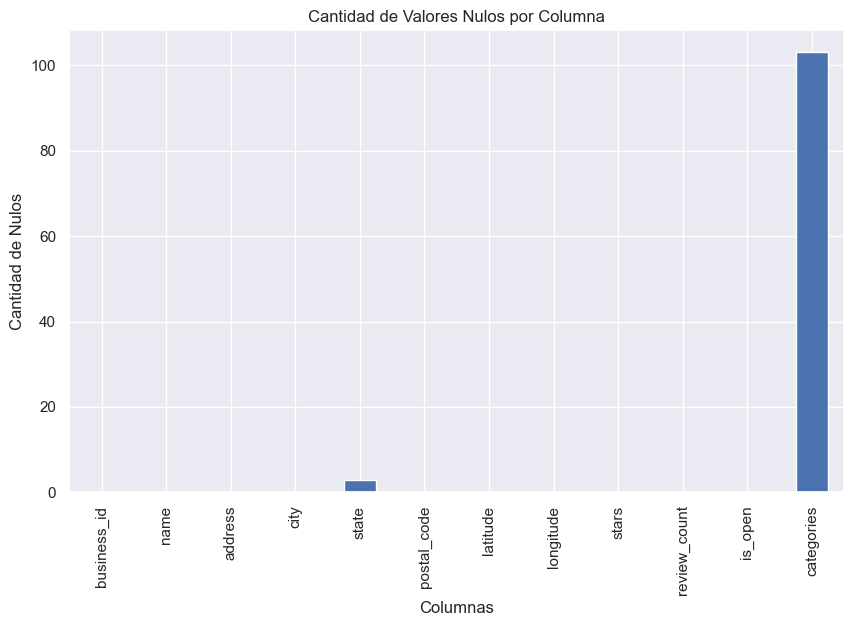

In [11]:
null_counts = business.isnull().sum()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Nulos')
plt.show()

quitar estos valores faltantes no cambia significativamente la estructura del dataset

In [12]:
business.dropna(inplace=True)

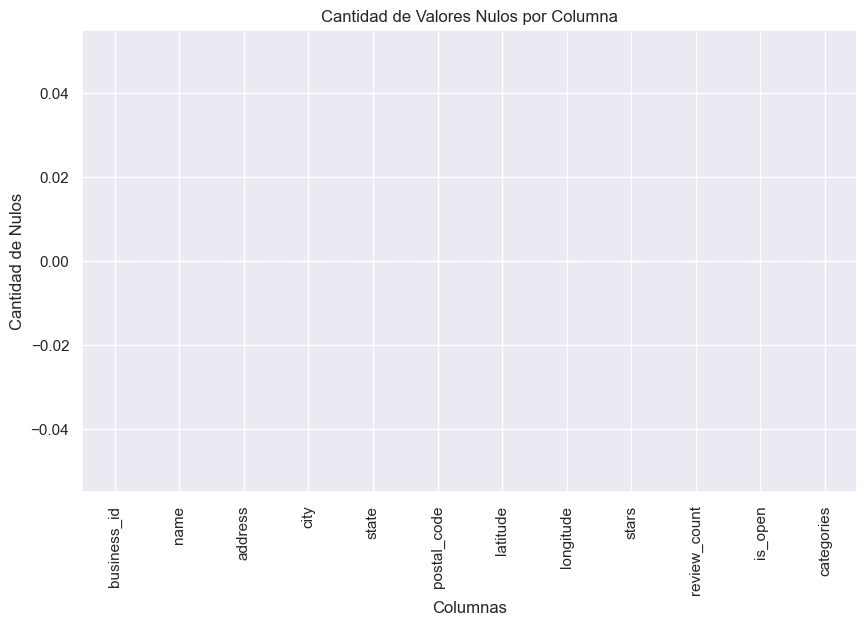

In [13]:

null_counts = business.isnull().sum()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Nulos')
plt.show()

##### Se desanida y visualiza la columna "categories"

In [14]:
# Divide la cadena por comas y utilizar la función explode para desanidar
business['categories'] = business['categories'].str.split(', ')
business = business.explode('categories')

In [15]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.96,-75.16,4.00,80,1,Restaurants
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.96,-75.16,4.00,80,1,Food
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.96,-75.16,4.00,80,1,Bubble Tea
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.96,-75.16,4.00,80,1,Coffee & Tea
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.96,-75.16,4.00,80,1,Bakeries


Hay que tener presenta que ahora existen varios registros que poseen distintas categorías, correspondiendo cada una al mismo negocio

**De acuerdo al objetivo del proyecto, el foco de estudio se centrará en el análisis del mercado de restaurantes del estado de Florida.**

Para comprender mejor este mercado, se realizarán algunos gráficos de visualización.

### Top 10 categorías

Se visualizan las categorías con mayor cantidad de negocios en el estado de Florida

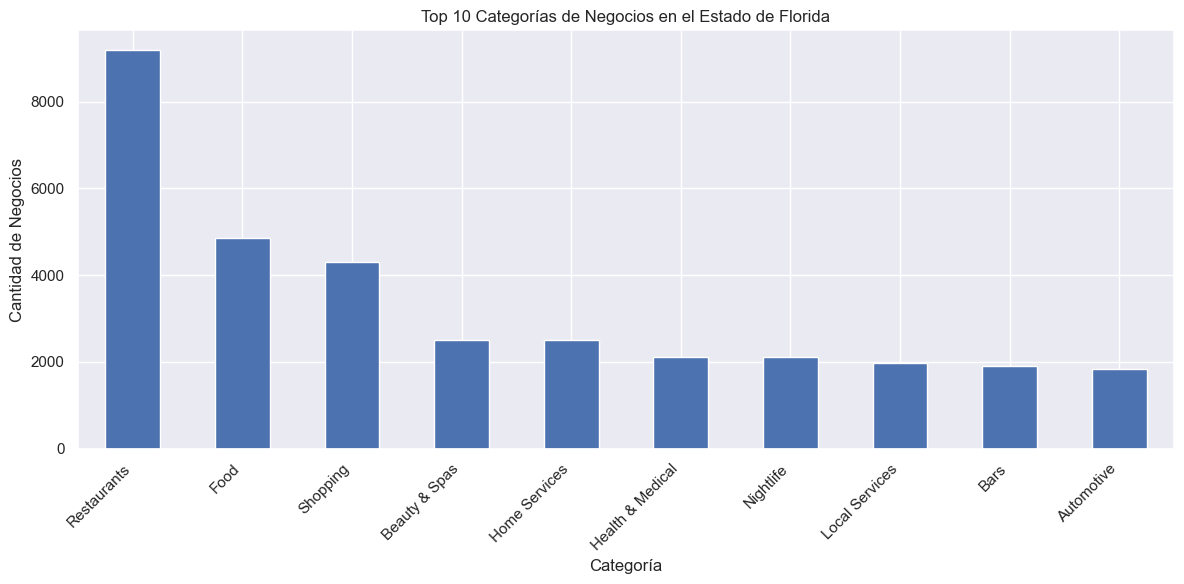

In [16]:
# Filtra el DataFrame para obtener solo negocios en el estado de Florida
df_florida = business[business['state'] == 'FL']

# Calcula la cantidad de negocios por cada categoría
categorias_count = df_florida['categories'].str.split(', ', expand=True).stack().value_counts()

# Filtra las categorías con más de 10 negocios para una visualización más clara
categorias_count = categorias_count[categorias_count > 10]

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
categorias_count.head(10).plot(kind='bar')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Negocios')
plt.title('Top 10 Categorías de Negocios en el Estado de Florida')
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Se puede observar que la mayoría de los negocios poseen la categoría "Restaurants", aunque es cierto que también muchos de ellos poseen también otras categorías más

### Restaurantes con más reviews en Florida

Se convierten las columnas _`stars`_ y _`review_count`_ a formato numérico.

In [17]:
# Convierte las columnas 'stars' y 'review_count' a formato numérico
business['stars'] = pd.to_numeric(business['stars'], errors='coerce')
business['review_count'] = pd.to_numeric(business['review_count'], errors='coerce')

Se realiza el filtro para luego visualizar el gráfico

Top 10 Restaurantes con Más Reseñas en Florida:
['Oceana Grill', 'Ruby Slipper - New Orleans', 'The Pharmacy', 'Café Amelie', "Jim's South St", 'The Eagle', 'Bourbon House', 'Sampan', 'Palace Café', 'Salt + Smoke']


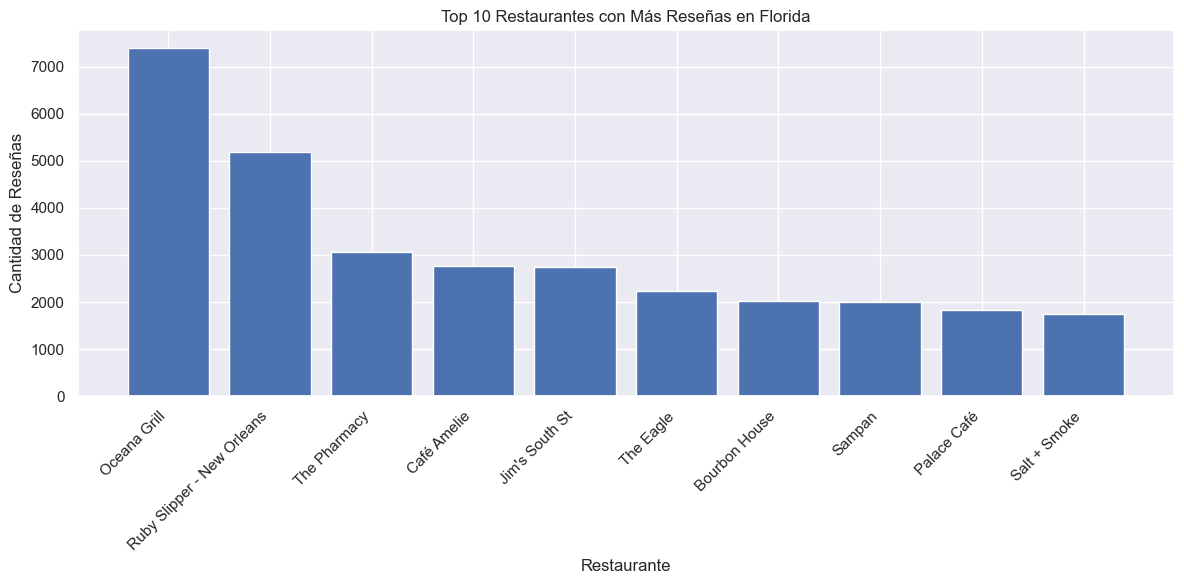

In [19]:
# Filtra el DataFrame para obtener solo negocios en la categoría de "Restaurants" en el estado de Florida
df_florida_restaurants = business[(business['state'] == 'FL') & (business['categories'].str.contains('Restaurants', case=False, na=False))]

# Ordena de mayor a menor por la cantidad de reseñas y toma el top 10
top_10_restaurants = df_florida_restaurants.sort_values(by='review_count', ascending=False).head(10)

if not top_10_restaurants.empty:
    # Imprime los nombres de los restaurantes
    print("Top 10 Restaurantes con Más Reseñas en Florida:")
    print(top_10_restaurants['name'].tolist())

    # Crea el gráfico de barras
    plt.figure(figsize=(12, 6))
    plt.bar(top_10_restaurants['name'], top_10_restaurants['review_count'])
    plt.xlabel('Restaurante')
    plt.ylabel('Cantidad de Reseñas')
    plt.title('Top 10 Restaurantes con Más Reseñas en Florida')
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para graficar.")

### Top 10 comercios de comida rápida en Florida

Filtramos las etiquetas **Food** que figura segundo en el ranking

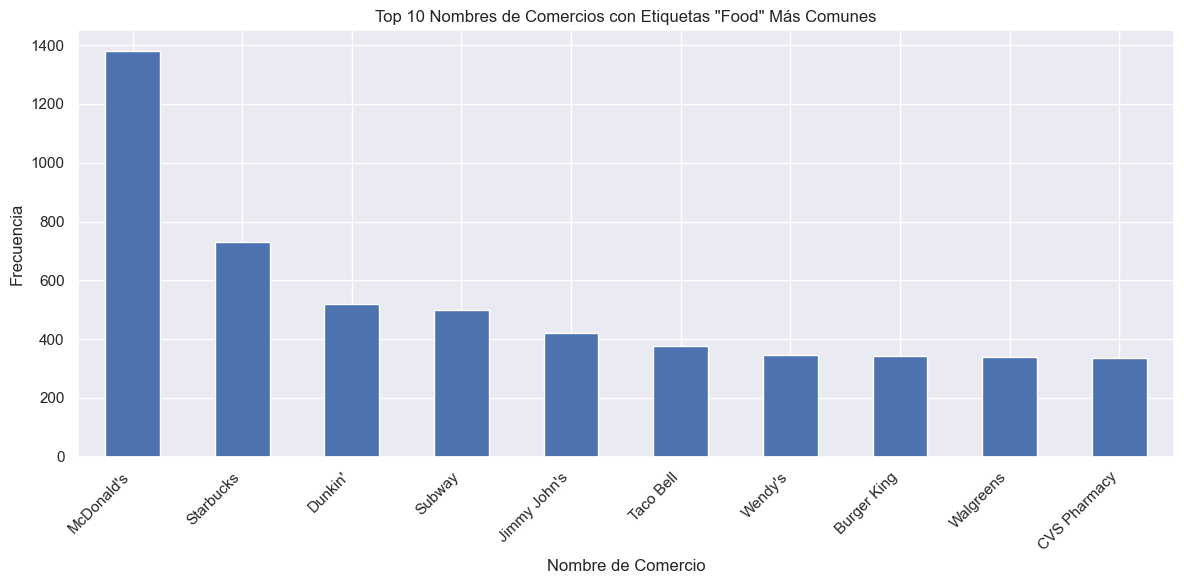

In [20]:
# Filtra el DataFrame para obtener solo los negocios con etiquetas de "Food"
food_businesses = business[business['categories'].str.contains('Food', case=False, na=False)]

# Cuenta la frecuencia de cada nombre de comercio
names_count = food_businesses['name'].value_counts()

# Toma el top 10 de nombres de comercios más comunes
top_10_names = names_count.head(10)

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
top_10_names.plot(kind='bar')
plt.xlabel('Nombre de Comercio')
plt.ylabel('Frecuencia')
plt.title('Top 10 Nombres de Comercios con Etiquetas "Food" Más Comunes')
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


### Top 10 comercios del tipo "Bars" en Florida

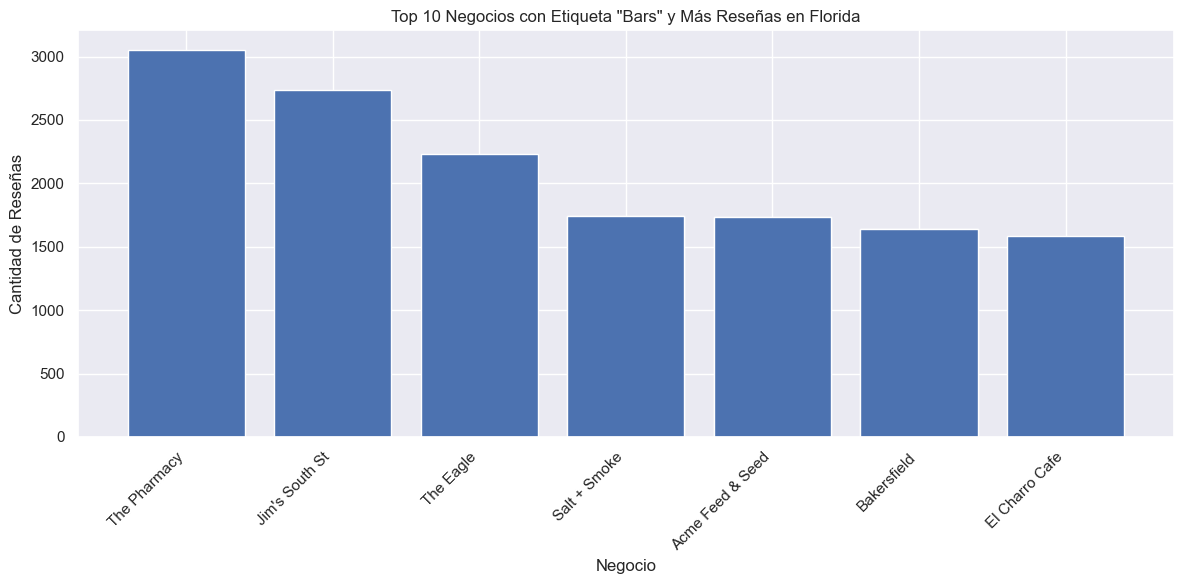

In [21]:
# Filtra el DataFrame para obtener solo negocios con la etiqueta "Bars" en la columna de categorías en el estado de Florida
df_florida_bars = business[(business['state'] == 'FL') & (business['categories'].str.contains('Bars', case=False, na=False))]

# Ordena de mayor a menor por la cantidad de reseñas y toma el top 10
top_10_bars = df_florida_bars.sort_values(by='review_count', ascending=False).head(10)

# Crea el gráfico de barras con la cantidad de reseñas
plt.figure(figsize=(12, 6))
plt.bar(top_10_bars['name'], top_10_bars['review_count'])
plt.xlabel('Negocio')
plt.ylabel('Cantidad de Reseñas')
plt.title('Top 10 Negocios con Etiqueta "Bars" y Más Reseñas en Florida')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Dimensión final de _`business`_

In [23]:
business.shape

(668575, 12)

## **_`CHECKIN`_**

In [26]:

data_list = []

with open('Yelp/checkin.json', 'r') as file:
    for line in file:
        try:
            item = json.loads(line)
            data_list.append(item)
        except json.JSONDecodeError:
            pass

In [27]:
checkin = pd.DataFrame(data_list)

In [28]:
checkin.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


La columna _`date`_ contiene datos separados por coma. Se separará el dataset de acuerdo a las fechas por coma

In [29]:
separated_dates = []

for index, row in checkin.iterrows():
    dates = row['date'].split(', ')
    for date in dates:
        separated_dates.append([row['business_id'], date])

new_columns = ['business_id', 'date']
checkin = pd.DataFrame(separated_dates, columns=new_columns)

Se cambia el formato de la columna _`date`_ a formato datetime

In [30]:
checkin['date'] = pd.to_datetime(checkin['date'])

##### Valores nulos

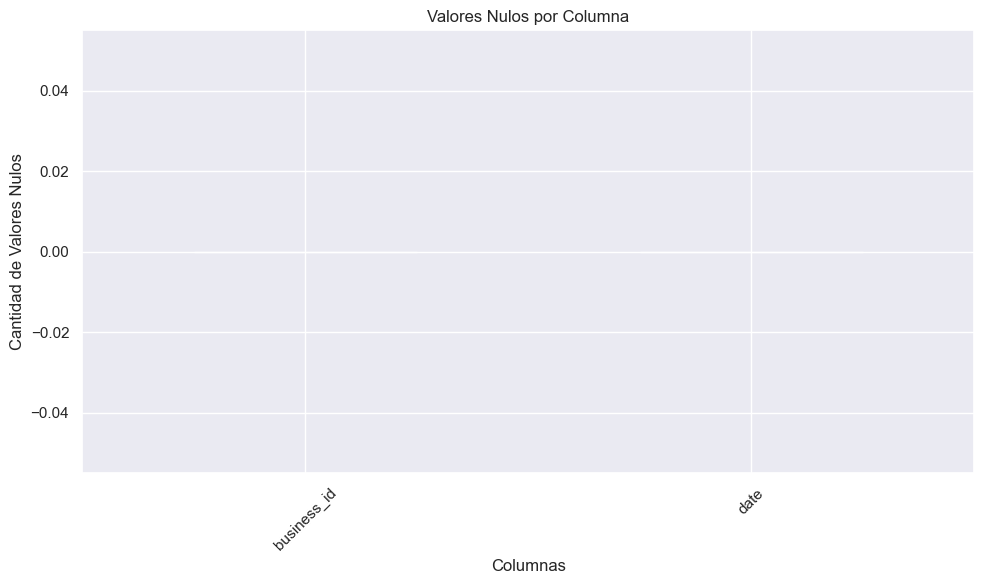

In [31]:
null_counts = checkin.isnull().sum()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Valores Nulos por Columna')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No hay valores nulos

### Visualización del número de check-ins por Año

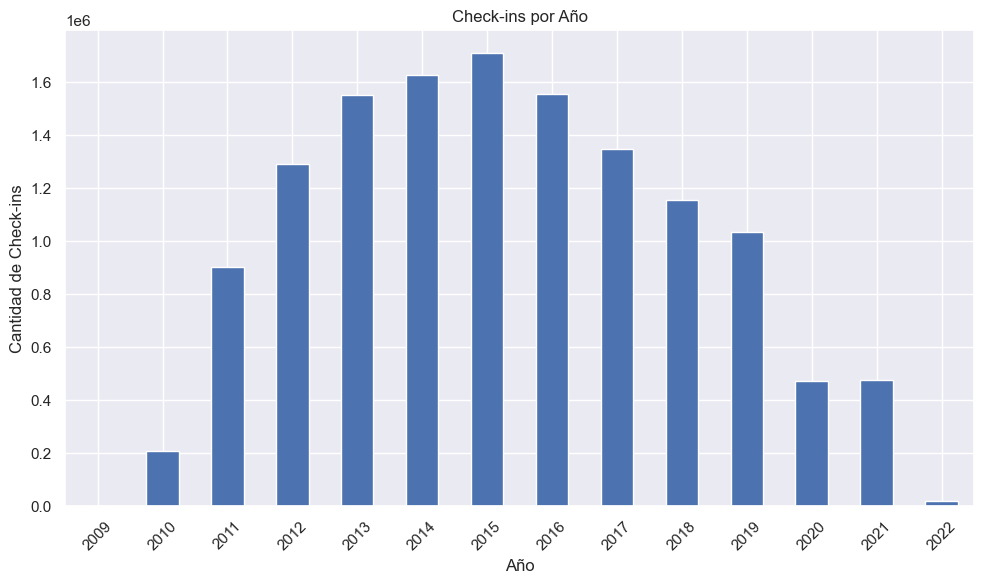

In [33]:
# Agrupa los datos por año y cuenta la cantidad de eventos de check-in en cada año
checkin_grouped = checkin.groupby(checkin['date'].dt.year).size()

plt.figure(figsize=(10, 6))
checkin_grouped.plot(kind='bar')
plt.xlabel('Año')
plt.ylabel('Cantidad de Check-ins')
plt.title('Check-ins por Año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Nota: La escala en este gráfico se representó en notación científica porque los números son muy grandes. Por ejemplo, 1e6 equivale a 1000000.**

### Para mayor análisis, los check-ins se filtraran por años

### Años 2020 - 2021 y 2022

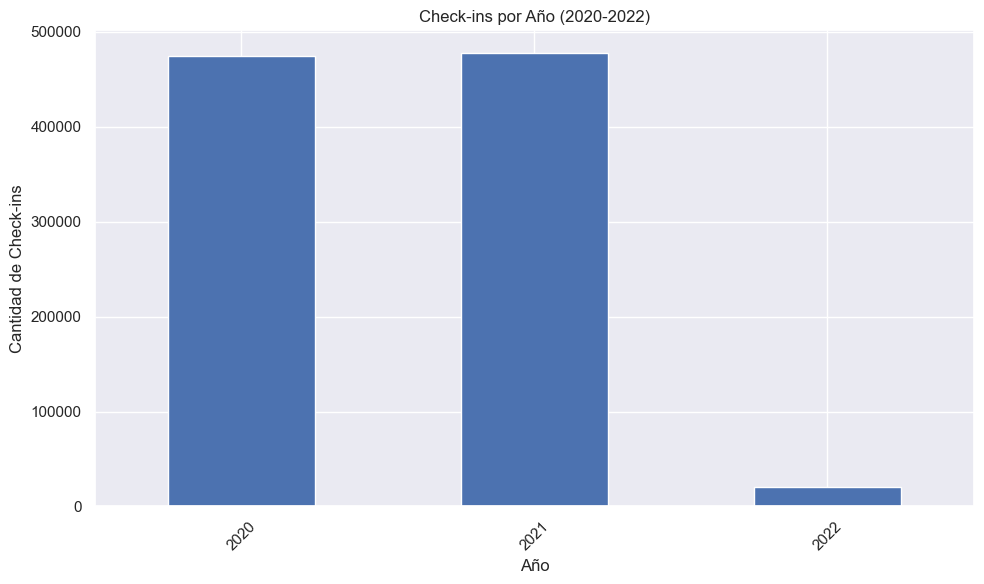

In [34]:
# Se filtran los datos para incluir solo los años 2020, 2021 y 2022
checkin_filtered = checkin[checkin['date'].dt.year.isin([2020, 2021, 2022])]

# Agrupa los datos por año y cuenta la cantidad de eventos de check-in en cada año
checkin_grouped = checkin_filtered.groupby(checkin_filtered['date'].dt.year).size()

# Finalmente se crea un gráfico de barras para la cantidad de check-ins por año
plt.figure(figsize=(10, 6))
checkin_grouped.plot(kind='bar')
plt.xlabel('Año')
plt.ylabel('Cantidad de Check-ins')
plt.title('Check-ins por Año (2020-2022)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Nota: Los check-ins en el año 2022 son muy pocos ya que solo disponemos hasta enero del 2022 para este dataframe.**

### Año 2020

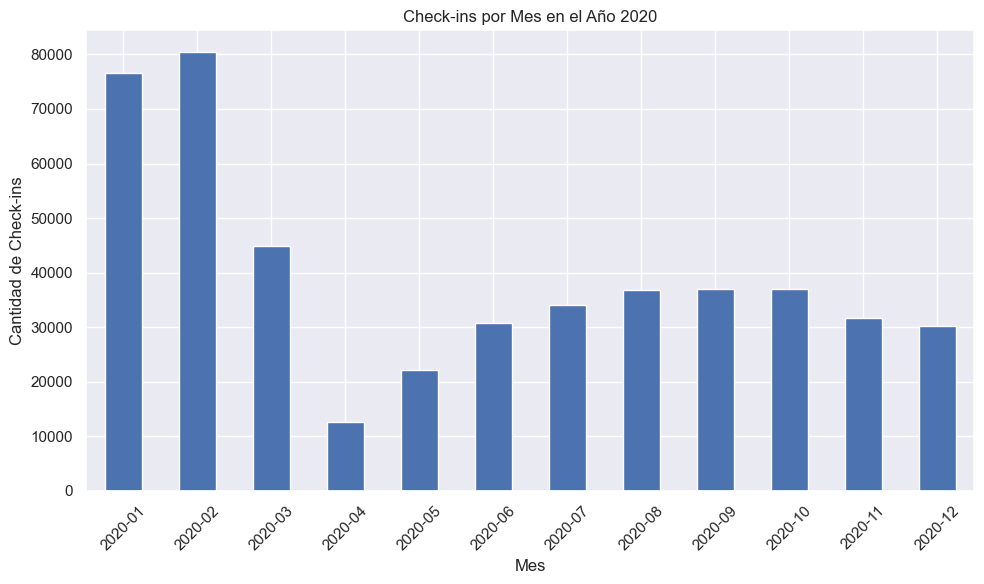

In [35]:
# Se filtran los datos para incluir solo el año 2020
checkin_2020 = checkin[checkin['date'].dt.year == 2020]

# Se crea un índice con todos los meses del año 2020
months_index = pd.period_range(start='2020-01', end='2020-12', freq='M')

# Se agrupan los datos por mes y cuenta la cantidad de eventos de check-in en cada mes
checkin_grouped = checkin_2020.groupby(checkin_2020['date'].dt.to_period('M')).size()

# Reindexar para incluir todos los meses y llenar valores faltantes con ceros
checkin_grouped = checkin_grouped.reindex(months_index, fill_value=0)

# Finamente se crea un gráfico de barras para la cantidad de check-ins por mes en el año 2022
plt.figure(figsize=(10, 6))
checkin_grouped.plot(kind='bar',)
plt.xlabel('Mes')
plt.ylabel('Cantidad de Check-ins')
plt.title('Check-ins por Mes en el Año 2020')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En este gráfico se puede visualizar que en abril hubo mayor caída en los check-ins, esto podría estar relacionado con la pandemia.

### Año 2021

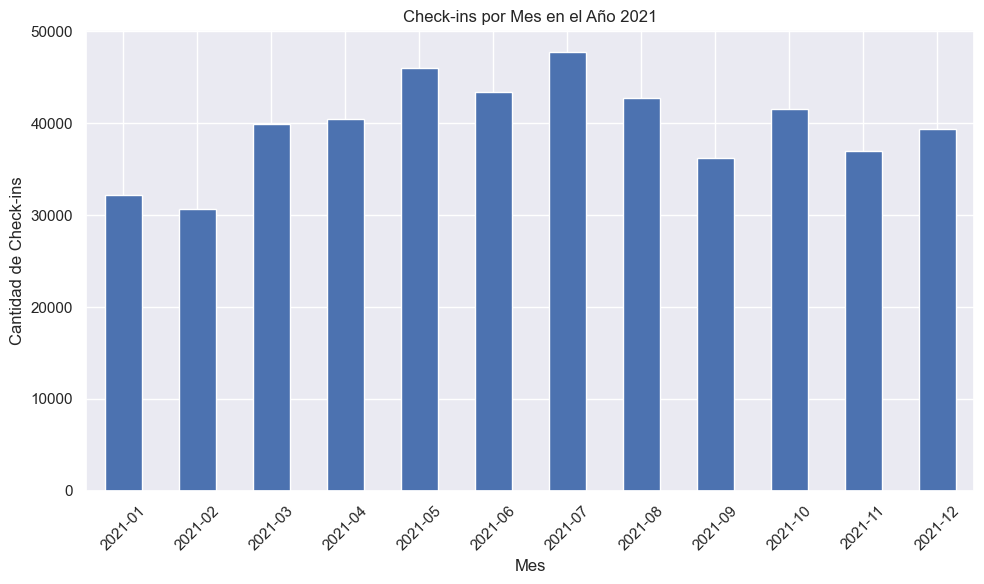

In [36]:
# Se filtran los datos para incluir solo el año 2021
checkin_2021 = checkin[checkin['date'].dt.year == 2021]

# Se Crea un índice con todos los meses del año 2021
months_index = pd.period_range(start='2021-01', end='2021-12', freq='M')

# Agrupa los datos por mes y cuenta la cantidad de eventos de check-in en cada mes
checkin_grouped = checkin_2021.groupby(checkin_2021['date'].dt.to_period('M')).size()

# Reindexar para incluir todos los meses y llenar valores faltantes con ceros
checkin_grouped = checkin_grouped.reindex(months_index, fill_value=0)

# Finalmente se crea un gráfico de barras para la cantidad de check-ins por mes en el año 2021
plt.figure(figsize=(10, 6))
checkin_grouped.plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Check-ins')
plt.title('Check-ins por Mes en el Año 2021')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Año 2022

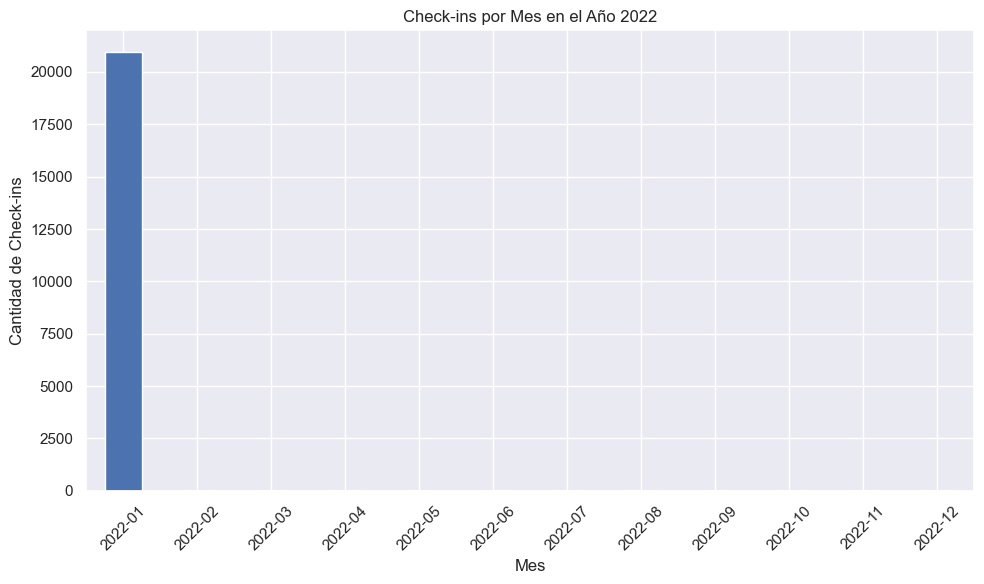

In [37]:
# Se filtran los datos para incluir solo el año 2022
checkin_2022 = checkin[checkin['date'].dt.year == 2022]

# Se crea un índice con todos los meses del año 2022
months_index = pd.period_range(start='2022-01', end='2022-12', freq='M')

# Se agrupan los datos por mes y cuenta la cantidad de eventos de check-in en cada mes
checkin_grouped = checkin_2022.groupby(checkin_2022['date'].dt.to_period('M')).size()

# Reindexar para incluir todos los meses y llenar valores faltantes con ceros
checkin_grouped = checkin_grouped.reindex(months_index, fill_value=0)

# finalmente se crea un gráfico de barras para la cantidad de check-ins por mes en el año 2021
plt.figure(figsize=(10, 6))
checkin_grouped.plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Check-ins')
plt.title('Check-ins por Mes en el Año 2022')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Los datos que proveen este dataset llegan hasta enero del año 2022.

Dimensión final de _`checkin`_

In [38]:
checkin.shape

(13356875, 2)

## **_`TIP`_**

In [74]:
data_list = []

with open('Yelp/tip.json', 'r', encoding='utf-8') as file:
    for line in file:
        try:
            item = json.loads(line)
            data_list.append(item)
        except json.JSONDecodeError:
            pass 

In [75]:
tips = pd.DataFrame(data_list)

In [76]:
tips.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [77]:
tips.dtypes

user_id             object
business_id         object
text                object
date                object
compliment_count     int64
dtype: object

Se verifica la existencia de valores nulos

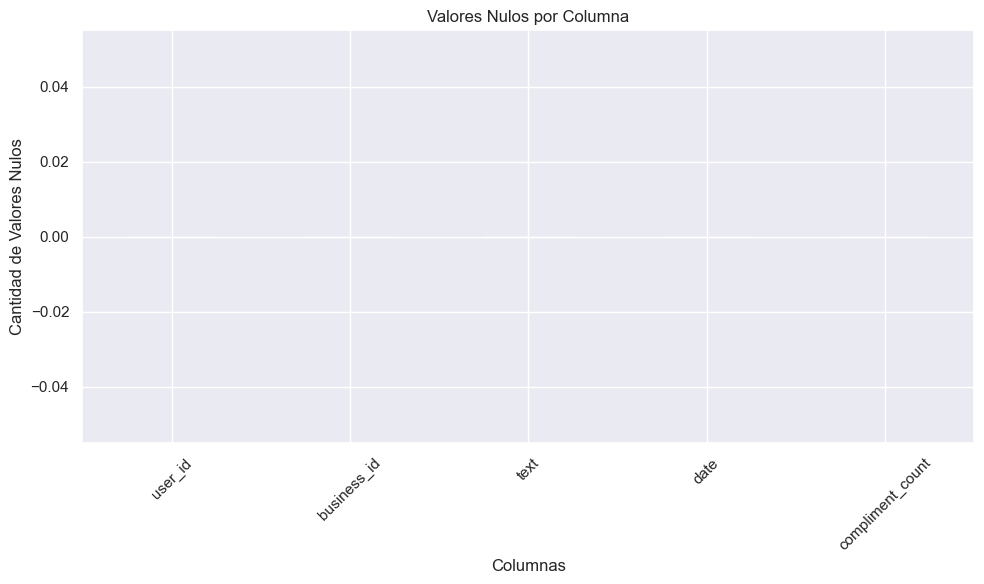

In [78]:
null_counts = tips.isnull().sum()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='red')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Valores Nulos por Columna')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No hay valores nulos

Dimensión final de _`tips`_

In [80]:
tips.shape

(908915, 5)